In [1]:
%matplotlib inline
from matplotlib import pyplot
import geopandas as gpd
import pandas as pd
import numpy as np

from weavingspace import TileUnit
from weavingspace import tiling_utils

import shapely.geometry as geom
import shapely.affinity as affine

In [2]:
t = TileUnit(tiling_type = "laves", n = 6, code = "3.3.3.3.6")
p = t.elements.geometry[0]
# p = geom.Polygon([(0, 0), (100, 0), (100, 50), (0, 50)])
pts = [geom.Point(x) for x in p.exterior.coords]
edges = [geom.LineString([p1, p2])
         for p1, p2 in zip(pts[:-1], pts[1:])]
midpts = [e.interpolate(0.5, normalized = True) for e in edges]
r = 2 * p.area / geom.LineString(p.exterior.coords).length
# edge_b = [e.buffer(r) for e in edges]
edge_b = [e.buffer(r + 1e-6, cap_style = 2) for e in edges]

In [3]:
x = edge_b[0].intersection(edge_b[1])
for b in edge_b[1:]:
    x = x.intersection(b)   
xc = x.centroid

<AxesSubplot:>

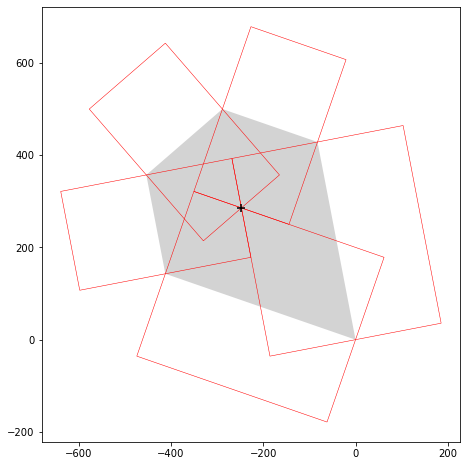

In [4]:
ax = gpd.GeoSeries([p]).plot(fc = "lightgrey", figsize = (8, 8))
gpd.GeoSeries(edge_b).plot(ax = ax, ec = "r", fc = "#00000000", lw = 0.5)
gpd.GeoSeries([xc]).plot(ax = ax, markersize = 50, marker = "+", color = "k")